In [1]:
# data manipulations
import numpy as np
import pandas as pd

# data preaparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# dealing with images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for writing the models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

# metrics 
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import AUC

#visualization
import matplotlib.pyplot as plt


In [2]:
def print_results(predictions, test):
    y_pred = np.argmax(predictions, axis=1)
    y_true = test.labels
    
    # confusion matrix
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    # classification report
    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred))


def graphing_training_validation(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('accuracy') 
    plt.xlabel('epoch')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('loss') 
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

Load images metadata

In [3]:
metadata = pd.read_csv("image_metadata.csv")
metadata.head()

,Path,Label
0,img_data/Bleatings/0.png,Bleatings
1,img_data/Bleatings/1.png,Bleatings
2,img_data/Bleatings/2.png,Bleatings
3,img_data/Bleatings/3.png,Bleatings
4,img_data/Bleatings/4.png,Bleatings


Split the data in train, validation and test set.

In [4]:
# get train/test dataframe
train_df, test_df = train_test_split(metadata, 
                                   test_size = 0.15, 
                                   random_state = 2018,
                                   stratify = metadata['Label'])
print(f'Train {np.shape(train_df)} and test {np.shape(test_df)}')

Train (5902, 2) and test (1042, 2)


Prepare train and validation iamges

In [5]:
path_dir = "./"

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    validation_split = 0.17655)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path_dir,
    x_col="Path",
    y_col="Label",
    batch_size=32,
    shuffle=True,
    target_size=(256, 256),
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path_dir,
    x_col="Path",
    y_col="Label",
    batch_size=32,
    shuffle=True,
    target_size=(256, 256),
    class_mode='categorical',
    subset='validation'
)

Found 4861 validated image filenames belonging to 3 classes.
Found 1041 validated image filenames belonging to 3 classes.


Prepare test images

In [6]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path_dir,
    x_col="Path",
    y_col="Label",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(256, 256))

Found 1042 validated image filenames belonging to 3 classes.


# Convolutional Neural Network on log Mel-spectrogram images

Next I'm going to train 3 CNN models to find out which is the best model.<br>Follow the definition of some fixed parameters for training like optimizer and early stopping.

In [7]:
input_size = (256, 256, 3)
adam = keras.optimizers.Adam(learning_rate=0.001)
batchsize = 32
epochs = 50
metrics = [
    "accuracy",
    AUC(curve="ROC", name="auroc")
]
callbacks=[
    EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)
]

In [8]:
def compile_and_train(model, train, validation):
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=metrics)
    history = model.fit(train,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_data=validation,
                    callbacks=callbacks)
    return history, model

# Models Definition

In [35]:
# build a sequential model
model = Sequential([
    InputLayer(input_shape=input_size),
    # 1st conv block
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    # 2nd conv block
    Conv2D(16, (3, 3), activation='relu', strides=(2, 2), padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    # 3rd conv block
    Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    # ANN block
    Flatten(),
    Dropout(0.2),
    Dense(units=128, activation='relu'),
    Dense(units=32, activation='relu'),
    # output layer
    Dense(units=3, activation='softmax')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)             

In [36]:
model1 = Sequential([
    InputLayer(input_shape=input_size),
    #1st hidden layer
    Conv2D(16, (3, 3), activation='relu', padding="same"),
    MaxPool2D((2, 2)),
    #2nd hidden layer
    Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding="same"),
    MaxPool2D((2, 2)),
    # 3rd conv block
    Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    #ANN
    Flatten(),
    Dropout(0.2),
    Dense(units = 128, activation='relu'),
    Dense(units = 64, activation='relu'),
    #Output layer
    Dense(units= 3, activation='softmax'),
]) 
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4096)             

In [37]:
model2 = tf.keras.models.Sequential([
    InputLayer(input_shape=input_size),
    #first_convolution
    Conv2D(16, (3,3), activation='relu'),
    MaxPool2D(2, 2),
    #second_convolution
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D(2,2),
    #third_convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(2,2),
    #fourth_convolution
    Conv2D(64, (3,3), strides=(2, 2), activation='relu'),
    MaxPool2D(2,2),
    #out ANN
    Flatten(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax') 
]) 
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 64)       

## First CNN 

In [38]:
history, model = compile_and_train(model, train_generator, validation_generator)

Epoch 1/50
152/152 [==============================] - 28s 176ms/step - loss: 0.6872 - accuracy: 0.6390 - auroc: 0.8515 - val_loss: 0.5101 - val_accuracy: 0.7560 - val_auroc: 0.9222
Epoch 2/50
152/152 [==============================] - 28s 185ms/step - loss: 0.5031 - accuracy: 0.7422 - auroc: 0.9174 - val_loss: 0.4735 - val_accuracy: 0.7704 - val_auroc: 0.9316
Epoch 3/50
152/152 [==============================] - 28s 184ms/step - loss: 0.4532 - accuracy: 0.7830 - auroc: 0.9371 - val_loss: 0.4076 - val_accuracy: 0.8040 - val_auroc: 0.9504
Epoch 4/50
152/152 [==============================] - 31s 204ms/step - loss: 0.3980 - accuracy: 0.8114 - auroc: 0.9518 - val_loss: 0.3733 - val_accuracy: 0.8357 - val_auroc: 0.9606
Epoch 5/50
152/152 [==============================] - 32s 210ms/step - loss: 0.3637 - accuracy: 0.8303 - auroc: 0.9605 - val_loss: 0.3699 - val_accuracy: 0.8280 - val_auroc: 0.9592
Epoch 6/50
152/152 [==============================] - 30s 194ms/step - loss: 0.3386 - accuracy:

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auroc', 'val_loss', 'val_accuracy', 'val_auroc'])

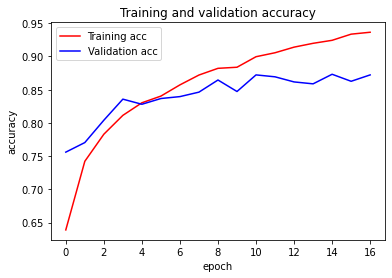

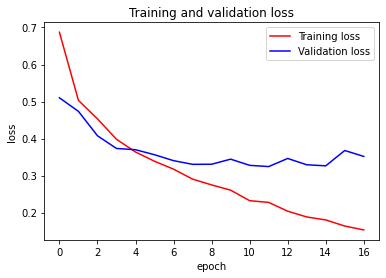

In [40]:
graphing_training_validation(history)

In [41]:
test_accuracy = model.evaluate(validation_generator)

33/33 [==============================] - 5s 137ms/step - loss: 0.3243 - accuracy: 0.8694 - auroc: 0.9715


In [42]:
prediction = model.predict(test_generator)

In [43]:
print_results(prediction, test_generator)

Confusion matrix:
[[284  61   4]
 [ 64 256   3]
 [  7   2 361]]

Classification report:

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       349
           1       0.80      0.79      0.80       323
           2       0.98      0.98      0.98       370

    accuracy                           0.86      1042
   macro avg       0.86      0.86      0.86      1042
weighted avg       0.87      0.86      0.86      1042



## Second CNN

In [44]:
history1, model1 = compile_and_train(model1, train_generator, validation_generator)

Epoch 1/50
152/152 [==============================] - 30s 186ms/step - loss: 0.6789 - accuracy: 0.6534 - auroc: 0.8853 - val_loss: 0.5297 - val_accuracy: 0.7301 - val_auroc: 0.9095
Epoch 2/50
152/152 [==============================] - 28s 186ms/step - loss: 0.5130 - accuracy: 0.7324 - auroc: 0.9150 - val_loss: 0.4928 - val_accuracy: 0.7339 - val_auroc: 0.9167
Epoch 3/50
152/152 [==============================] - 31s 204ms/step - loss: 0.4713 - accuracy: 0.7636 - auroc: 0.9288 - val_loss: 0.4308 - val_accuracy: 0.8002 - val_auroc: 0.9431
Epoch 4/50
152/152 [==============================] - 28s 182ms/step - loss: 0.4217 - accuracy: 0.7994 - auroc: 0.9446 - val_loss: 0.4058 - val_accuracy: 0.8040 - val_auroc: 0.9508
Epoch 5/50
152/152 [==============================] - 28s 182ms/step - loss: 0.4005 - accuracy: 0.8064 - auroc: 0.9503 - val_loss: 0.3888 - val_accuracy: 0.8204 - val_auroc: 0.9547
Epoch 6/50
152/152 [==============================] - 29s 192ms/step - loss: 0.3811 - accuracy:

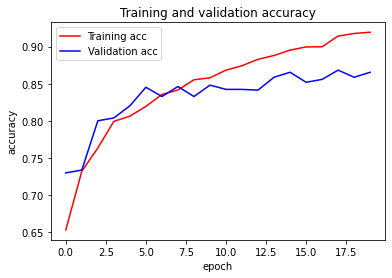

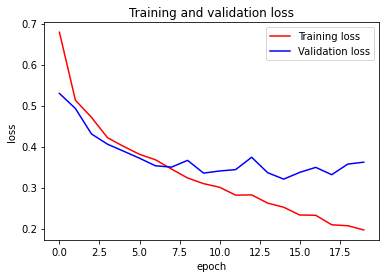

In [45]:
graphing_training_validation(history1)

In [46]:
test_accuracy = model1.evaluate(validation_generator)

33/33 [==============================] - 5s 140ms/step - loss: 0.3206 - accuracy: 0.8655 - auroc: 0.9704


In [47]:
pred1 = model1.predict(test_generator)
print_results(pred1, test_generator)

Confusion matrix:
[[268  76   5]
 [ 59 263   1]
 [ 13   2 355]]

Classification report:

              precision    recall  f1-score   support

           0       0.79      0.77      0.78       349
           1       0.77      0.81      0.79       323
           2       0.98      0.96      0.97       370

    accuracy                           0.85      1042
   macro avg       0.85      0.85      0.85      1042
weighted avg       0.85      0.85      0.85      1042



## Third CNN 

In [48]:
history2, model2 = compile_and_train(model2, train_generator, validation_generator)

Epoch 1/50
152/152 [==============================] - 38s 243ms/step - loss: 0.6950 - accuracy: 0.6371 - auroc: 0.8787 - val_loss: 0.5349 - val_accuracy: 0.7329 - val_auroc: 0.9060
Epoch 2/50
152/152 [==============================] - 39s 257ms/step - loss: 0.5234 - accuracy: 0.7340 - auroc: 0.9114 - val_loss: 0.4594 - val_accuracy: 0.7695 - val_auroc: 0.9332
Epoch 3/50
152/152 [==============================] - 39s 257ms/step - loss: 0.4770 - accuracy: 0.7546 - auroc: 0.9245 - val_loss: 0.4462 - val_accuracy: 0.7743 - val_auroc: 0.9375
Epoch 4/50
152/152 [==============================] - 39s 255ms/step - loss: 0.4473 - accuracy: 0.7766 - auroc: 0.9357 - val_loss: 0.4459 - val_accuracy: 0.7848 - val_auroc: 0.9371
Epoch 5/50
152/152 [==============================] - 40s 266ms/step - loss: 0.4131 - accuracy: 0.8000 - auroc: 0.9469 - val_loss: 0.3779 - val_accuracy: 0.8175 - val_auroc: 0.9564
Epoch 6/50
152/152 [==============================] - 41s 267ms/step - loss: 0.3762 - accuracy:

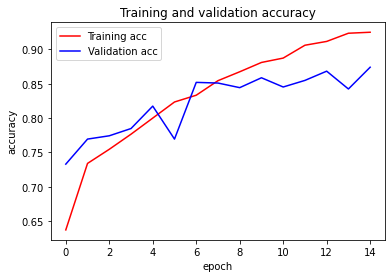

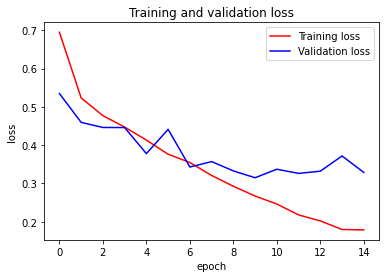

In [49]:
graphing_training_validation(history2)

In [50]:
test_accuracy = model2.evaluate(validation_generator)

33/33 [==============================] - 5s 156ms/step - loss: 0.3148 - accuracy: 0.8588 - auroc: 0.9705


In [51]:
pred2 = model2.predict(test_generator)
print_results(pred2, test_generator)

Confusion matrix:
[[263  82   4]
 [ 45 275   3]
 [ 10   6 354]]

Classification report:

              precision    recall  f1-score   support

           0       0.83      0.75      0.79       349
           1       0.76      0.85      0.80       323
           2       0.98      0.96      0.97       370

    accuracy                           0.86      1042
   macro avg       0.86      0.85      0.85      1042
weighted avg       0.86      0.86      0.86      1042

